# Introduction

In recent years, the application of computer vision in agriculture has gained significant traction due to its potential to revolutionize farming practices. One critical area where computer vision can make a substantial impact is in the classification of fruits and vegetables based on their health status. This project aims to develop a robust computer vision model using Keras, KerasCV, and TensorFlow to classify images of fruits and vegetables as either healthy or rotten.

The classification of fruits and vegetables is crucial for various stakeholders in the agricultural supply chain, including farmers, retailers, and consumers. For farmers, early detection of rotten produce can help in reducing waste and optimizing harvesting practices. For retailers, accurate classification can enhance inventory management and ensure that only high-quality products reach the shelves. For consumers, it provides assurance of the quality and safety of the produce they purchase.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Problem Statement
The primary objective of this project is to develop an efficient and accurate image classification model that can differentiate between rotten and healthy fruits and vegetables. The ability to automatically detect and classify the condition of produce is crucial for several reasons:


In [ ]:
!nvidia-smi

Tue Nov 19 18:35:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import shutil
import keras
import random
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import image_dataset_from_directory
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

fruits_data.

-> train (fresh & rotten).

-> test (fresh & rotten).

80% train : 70% training ->  10% validation,  
20% test

# Imports

In [ ]:
#gives the directories inside a capitol directory
def get_sub_dirs(directory):
    sub_dirs = []
    for root, _, _, in os.walk(directory):
        if root.split('/')[-1].split('__')[-1] in ['rotten', 'fresh']:
            sub_dirs.append(root)
    sub_dirs.sort()
    return sub_dirs
train_sub_dirs = get_sub_dirs('/content/drive/MyDrive/fruits_data/train')
test_sub_dirs = get_sub_dirs('/content/drive/MyDrive/fruits_data/test')

# diff types of images jpg, jpeg, png - converts into 1 type : jpg
def get_img_extensions_dict(dir_paths):
    img_extension_dict = {}
    for path in dir_paths:
        for filename in os.listdir(path):
            _, file_extension = os.path.splitext(filename)
            if file_extension not in img_extension_dict:
                img_extension_dict[file_extension] = 1
            else:
                img_extension_dict[file_extension] += 1
    return img_extension_dict

# different forms of color for diff images - converts images into 1 type of color channel representation
def count_color_channels(folder_paths):
    channel_counts = {}
    mode_to_channels = {'L': 1, 'LA': 2, 'P': 1, 'RGB': 3, 'RGBA': 4, 'CMYK': 4, 'YCbCr': 3, 'HSV': 3, 'LAB': 3, 'I': 1, 'F': 1}
    for folder_path in folder_paths:
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            try:
                with Image.open(file_path) as img:
                    mode = img.mode
                    channels = mode_to_channels.get(mode)
                    if channels is not None:
                        if channels in channel_counts:
                            channel_counts[channels] += 1
                        else:
                            channel_counts[channels] = 1
                    else:
                        print(f"Unrecognized mode {mode} for file {file_path}")
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

    return channel_counts

color_channel_counts = count_color_channels(train_sub_dirs)
print(color_channel_counts)


{3: 842}


resNet50 - overfitted

In [ ]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up ImageDataGenerator with ResNet50 preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2  # Optionally use a subset of training data for validation
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# Define paths to train and test directories
train_dir = '/content/drive/MyDrive/fruits_data/train'  # Adjust to your specific path in Drive
test_dir =  '/content/drive/MyDrive/fruits_data/test'   # Adjust to your specific path in Drive

# Create train and test generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Use 'categorical' if you have more than two classes
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 675 images belonging to 2 classes.
Found 167 images belonging to 2 classes.
Found 354 images belonging to 2 classes.


842 training (validation + training) images - 16 processed per batch.

Runs 22 times to run all images - 16x22 = 1 epoch



sigmoid output is the probability of the image it is currently processing : 50% > is freshness / rottenness.      

the other 50 is the other class


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define ResNet50 base model
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
)

# Modify the model with input resizing, dropout, and additional layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Dropout(0.5)(x)  # Add a dropout layer with 50% dropout rate
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # 'sigmoid' for binary classification
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.AdamW(1e-4),
    metrics=['accuracy']
)

# Print the model summary
model.summary()

# Define callbacks for early stopping and learning rate reduction
# if accuracy is not going up from what it has learned, then stop
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    callbacks=[]
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.7482 - loss: 0.5535 - val_accuracy: 0.9222 - val_loss: 0.3014
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 506ms/step - accuracy: 0.9922 - loss: 0.0308 - val_accuracy: 0.9341 - val_loss: 0.2847
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 525ms/step - accuracy: 0.9935 - loss: 0.0168 - val_accuracy: 0.9521 - val_loss: 0.2147
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 518ms/step - accuracy: 0.9992 - loss: 0.0080 - val_accuracy: 0.9641 - val_loss: 0.1148
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - accuracy: 0.9974 - loss: 0.0149 - val_accuracy: 0.9581 - val_loss: 0.2387
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 523ms/step - accuracy: 0.9990 - loss: 0.0076 - val_accuracy: 0.9341 - val_loss: 0.3068
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 509ms/step - accuracy: 0.9922 - loss: 0.0248 - val_accuracy: 0.9281 - val_loss: 0.2515
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 518ms/step - accuracy: 0.9936 - loss: 0.0151 - val_accurac

# Plotting the model accuracy and model loss

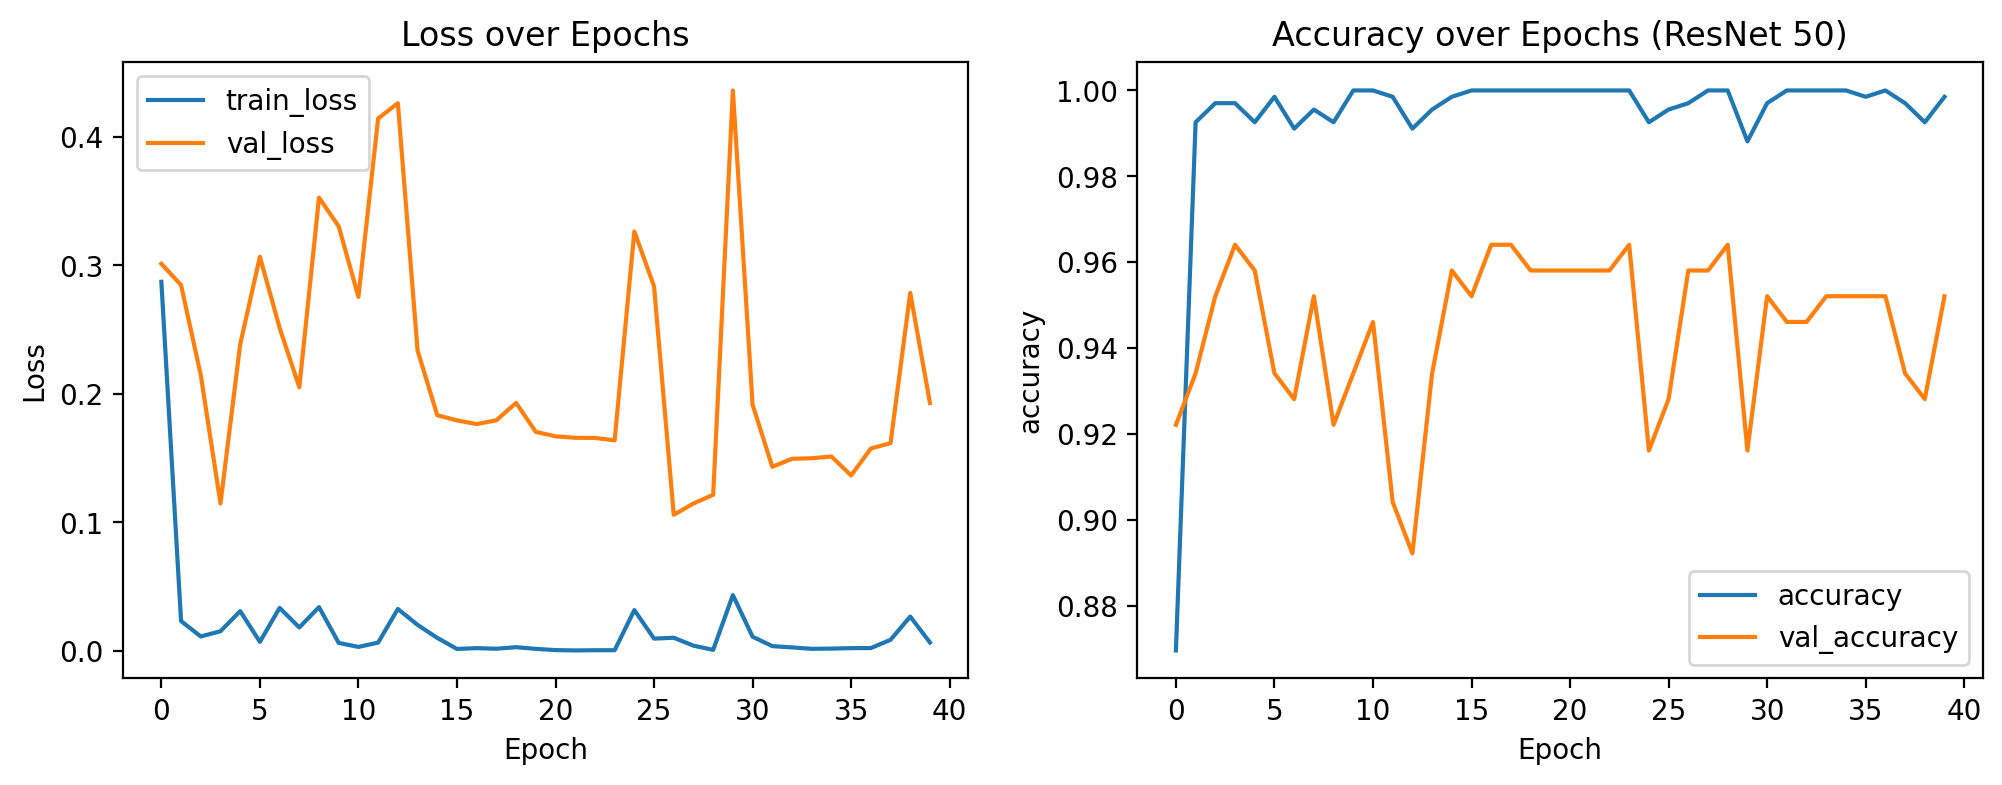

In [ ]:
plt.figure(figsize=(12, 4), dpi=200)
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy over Epochs (ResNet 50)')

plt.show();

graphs show overfitting


# Model Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class labels

# Get true labels from the generator
y_true = test_generator.classes

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# Confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred_classes))


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 277s 21s/step
Classification Report:

              precision    recall  f1-score   support

       fresh       0.49      0.52      0.51       176
      rotten       0.50      0.47      0.49       178

    accuracy                           0.50       354
   macro avg       0.50      0.50      0.50       354
weighted avg       0.50      0.50      0.50       354

Confusion Matrix:

[[92 84]
 [94 84]]


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights to handle any class imbalance
y_train = train_generator.classes  # Get labels from the training generator
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define EfficientNetB0 model
base_model = EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
)

# Unfreeze the top layers of EfficientNetB0 for fine-tuning
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers (adjust as needed)
    layer.trainable = True

# Modify the model with dropout and additional layers with regularization
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = tf.keras.layers.Dropout(0.5)(x)  # Dropout layer after the base model
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Dense layer with L2 regularization
x = tf.keras.layers.Dropout(0.5)(x)  # Additional dropout layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Output layer for binary classification
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    metrics=['accuracy']
)

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with class weights
history_1 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.5531 - loss: 4.9646 - val_accuracy: 0.5988 - val_loss: 4.9008 - learning_rate: 1.0000e-05
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 348ms/step - accuracy: 0.5536 - loss: 4.9640 - val_accuracy: 0.7186 - val_loss: 4.8507 - learning_rate: 1.0000e-05
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 337ms/step - accuracy: 0.6375 - loss: 4.8762 - val_accuracy: 0.7844 - val_loss: 4.8024 - learning_rate: 1.0000e-05
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.6416 - loss: 4.8434 - val_accuracy: 0.8443 - val_loss: 4.7527 - learning_rate: 1.0000e-05
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.7038 - loss: 4.7748 - val_accuracy: 0.8683 - val_loss: 4.7043 - learning_rate: 1.0000e-05
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.7516 - loss: 4.7272 - val_accuracy: 0.8922 - val_loss: 4.6595 - learning_rate: 1.0000e-05
Epoch 7/30
22

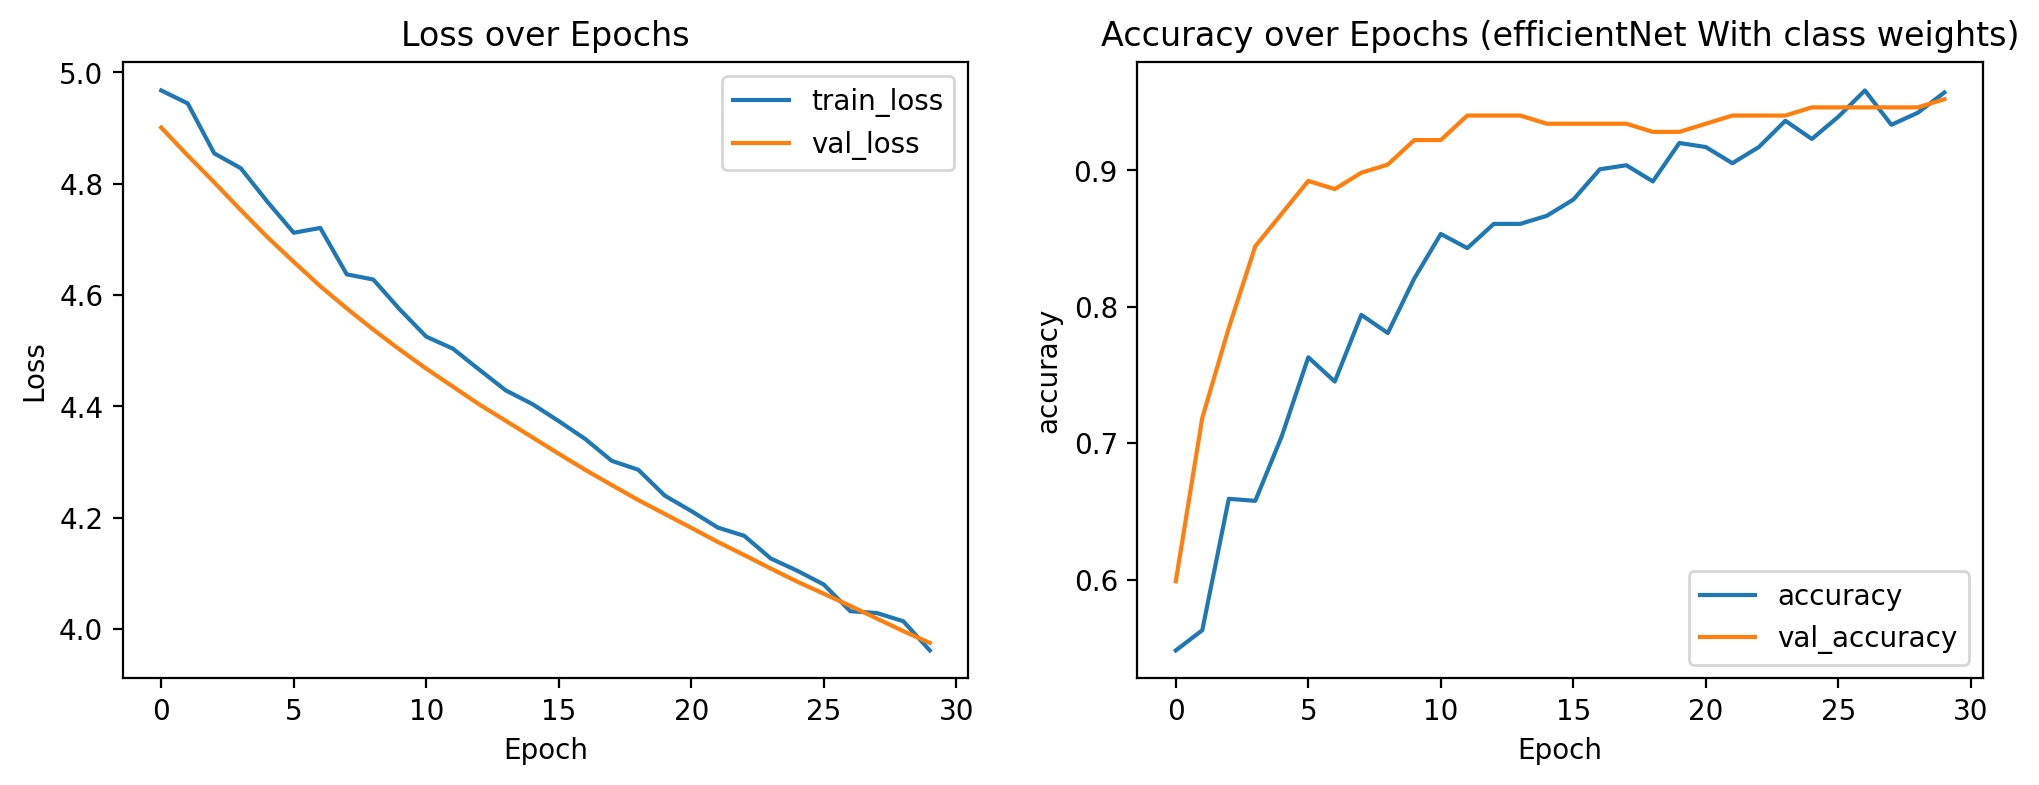

In [ ]:
plt.figure(figsize=(12, 4), dpi=200)
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='train_loss')
plt.plot(history_1.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_1.history['accuracy'], label='accuracy')
plt.plot(history_1.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy over Epochs (efficientNet With class weights)')

plt.show();

ResNet50 -  ~ 23.5 mil parameters - requires minimum 2,000 images

EfficentNet - Dynamically understands the global minimum and calculates accuracy accordingly . Residual connections and concept guidance. ~ 5.3 mil parameters.

Dataset too small for parameters to work properly - especially with ResNet50.

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class labels

# Get true labels from the generator
y_true = test_generator.classes

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes))

# Confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred_classes))
